In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import numpy as np 
import plotly.express as px
import matplotlib.pyplot as plt
# load utils
import utils as ut
pd.set_option('display.max.columns', 100)

Carga de archivos de los resultados, los resultados estan desagregados, entre drop3 y entropy.

In [303]:
def compute_metrics (row):
    #print(df)
    row['wtdAcc'] = 0.7*row['sensibility'] + 0.3*row['specificity']
    row['balancedAcc'] = (row['sensibility'] + row['specificity'])/2
    mcc_den = (row.tp+row.fp) * (row.tp + row.fn) * (row.tn+row.fp) * (row.tn+row.fn)
    #print(mcc_den)
    row['mcc'] = ((row.tp*row.tn) - (row.fp*row.fn))/ np.sqrt( float(mcc_den) )
    return (row)

In [304]:
# filter out the no instance selection and drop3
# carga de dataframe para entropy
entropy_results = ut.read_results("./data/is_experiments",  ["susyAllResults.csv"])
condition = (entropy_results.isMethod != 'drop3') & (entropy_results.instanceSelection != 'NOIS')
no_is_results =  entropy_results[entropy_results.instanceSelection == 'NOIS'].copy().reset_index(drop= True)
entropy_results = entropy_results[condition].copy().reset_index(drop= True)

In [305]:
entropy_results = entropy_results.apply(compute_metrics , axis = 1)
no_is_results = no_is_results.apply(compute_metrics , axis = 1)

--- 
para adaptar los resultados de rf puro

In [306]:
# resultados de rf
# we need to keep only best parameters
# of trees and depth, for each type (train-test)
rf_p2p = pd.read_csv("data/results_no_is/confusionAll.csv")
rf_p2p['k'] = rf_p2p.groupby([ 'trees', 'depth',  'impurity', 'bins', 'tipo'])['F1'].transform('rank')
print(rf_p2p.tipo.unique())
rf_p2p = rf_p2p.sort_values(['F1', 'trees', 'depth', 'tipo', 'k'], ascending = False).drop_duplicates(['trees', 'depth', 'tipo','k'])
print(rf_p2p.tipo.unique())
rf_p2p = rf_p2p.drop(['bins', 'impurity', 'PEXC', 'MCC'], axis =1).reset_index(drop = True)
print(rf_p2p.columns)
rf_p2p.columns = ['type', 'tp', 'fn', 'tn', 'fp', 'sensibility', 'specificity', 'precision', 'accuracy', 'F1', 'Gmean', 'AreaROC', 'trees', 'depth', 'k']
print(rf_p2p.type.unique())
rf_p2p_final = rf_p2p.copy().apply(lambda row : compute_metrics(row) , axis = 1)
rf_p2p_final['database'] = 'p2p'
print(rf_p2p_final.type.unique())

['test' 'train']
['train' 'test']
Index(['tipo', 'tp', 'fn', 'tn', 'fp', 'TPR', 'SPC', 'PPV', 'ACC', 'F1',
       'MGEO', 'areaRoc', 'trees', 'depth', 'k'],
      dtype='object')
['train' 'test']
['train' 'test']


In [307]:
ignore_cols = [] # ['subBuckets', 'buckAvg', 'reduction', 'buckets', 'buckMax', 'buckMin', 'timeIS', 'timeLSH']
missing_columns = (set(no_is_results.columns) - set(rf_p2p_final.columns)) - set(ignore_cols)
#fix_missing =  ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'instanceSelection']
print("missing", missing_columns)
cols_to_complete = no_is_results[missing_columns].copy().drop_duplicates(
    ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'instanceSelection']).reset_index(drop = True)
cols_to_complete['aux'] = 1
rf_p2p_final['aux'] = 1
rf_p2p_final = pd.merge(cols_to_complete, rf_p2p_final, how = 'left', on = 'aux').drop('aux', axis = 1)
no_is_results['type'] = no_is_results['type'].str.lower()
no_is_results = pd.concat([no_is_results[no_is_results.columns], rf_p2p_final[no_is_results.columns]], ignore_index=True)

missing {'distance', 'instanceSelection', 'sizeBucket', 'isMethod', 'buckets', 'ors', 'lshMEthod', 'buckMin', 'buckAvg', 'buckMax', 'ands', 'subBuckets', 'neigh', 'timeIS', 'reduction', 'imbalance', 'timeLSH'}



---


Ahora todos los resultados de drop3

In [308]:
# filter out the no instance selection and drop3
# carga de dataframe para entropy
drop3_files = ['boundaries.csv', "one.csv", "test.csv"]
drop3_results = ut.read_results("./data/drop3",  drop3_files)
condition = (drop3_results.isMethod == 'drop3') & (drop3_results.instanceSelection != 'NOIS')
drop3_results = drop3_results[condition].copy().reset_index(drop= True)
# in the drop3 the file have the db and the
# one sample bucket
drop3_results = drop3_results.apply(compute_metrics , axis = 1)
drop3_results[['database', 'one_class_method']] = drop3_results.database.str.replace(".csv", "").str.split("_", expand = True)

Now We will concatenate the results



In [309]:
entropy_results['one_class_method'] = 'entropy'
drop3_entropy = pd.concat([entropy_results, drop3_results], ignore_index=True)
# deduplicate records
drop3_entropy = drop3_entropy.drop_duplicates()

In [310]:
## add axiliary results        
drop3_entropy['Total Time'] = drop3_entropy.timeLSH + drop3_entropy.timeIS
drop3_entropy['total'] = drop3_entropy.tp + drop3_entropy.tn + drop3_entropy.fn + drop3_entropy.fp
drop3_entropy['samples by bucket average (relative)'] = drop3_entropy.buckAvg/drop3_entropy.total*100.0
drop3_entropy['model_complexity'] =  drop3_entropy.trees*drop3_entropy.depth
drop3_entropy['Reduction of DataSet(%)'] = (1 - drop3_entropy['reduction'])*100.0
drop3_entropy['type'] = drop3_entropy['type'].str.lower()

## Results Plots

### adapt the dataframes to plots

In [311]:
factorsModel = ['trees', 'depth']
cols_to_dedup = ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'database', 'k', 'type', 'instanceSelection'] + factorsModel

In [312]:
no_is_results.drop_duplicates(cols_to_dedup).groupby(['database', 
                        'instanceSelection',
                        'imbalance', 
                        'lshMEthod'])['tp'].count()

database    instanceSelection  imbalance  lshMEthod             
fraudk      NOIS               False      hyperplanes               450
                                          hyperplanes-projection    450
                                          projection                450
                               True       hyperplanes               450
                                          hyperplanes-projection    450
                                          projection                450
p2p         NOIS               False      hyperplanes               465
                                          hyperplanes-projection    465
                                          projection                465
                               True       hyperplanes               465
                                          hyperplanes-projection    465
                                          projection                465
pageblocks  NOIS               False      hyperplanes               450

In [313]:
measuresNoIS = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 
                'accuracy', 'F1', 'Gmean', 'wtdAcc','AreaROC', 'balancedAcc', 'mcc']


factorsNoIS = ['database', 'ands']
cols_to_dedup_noIs = ['ands', 'database', 'k', 'type'] +factorsModel
no_is_results_dp =  no_is_results.drop_duplicates(cols_to_dedup_noIs)
best_no_is = (no_is_results_dp.groupby(factorsNoIS)
                .apply(lambda g : ut.get_best_for(g, measuresNoIS, factorsModel = factorsModel, debug = False))
                .reset_index())

---
prueba

In [270]:
ands = (5*list(no_is_results.ands.unique()))
dfs = []
for db in no_is_results.database.unique():
    for ty in no_is_results.type.unique():
        df_partial = best_no_is[(best_no_is.database==db) & (best_no_is.type==ty)].copy()
        df_partial['ands'] = ands
        dfs.append(df_partial)
best_no_is = pd.concat(dfs, ignore_index=True)

---

In [314]:
drop3_entropy.drop_duplicates(cols_to_dedup).groupby(['database', 
                        'instanceSelection',
                        'imbalance', 
                        'lshMEthod']+ factorsModel)['tp'].count()

database    instanceSelection  imbalance  lshMEthod    trees  depth
fraudk      IS                 False      hyperplanes  10     10        50
                                                              20        50
                                                              30        50
                                                       25     10        50
                                                              20        50
                                                                      ... 
pageblocks  IS                 True       projection   25     20       100
                                                              30       100
                                                       50     10       100
                                                              20       100
                                                              30       100
Name: tp, Length: 162, dtype: int64

In [315]:
drop3_entropy.drop_duplicates(cols_to_dedup +[ 'one_class_method']).groupby(['database', 
                        'instanceSelection',
                        'one_class_method',
                        'imbalance', 
                        'lshMEthod']).agg({'tp': 'count', 'ands': 'unique', 'k': 'unique', 'trees': 'unique', 'depth': 'unique'})

tp  \
database   instanceSelection one_class_method imbalance lshMEthod                     
fraudk     IS                boundaries       True      hyperplanes             450   
                                                        hyperplanes-projection  450   
                                                        projection              450   
                             entropy          False     hyperplanes             450   
                                                        hyperplanes-projection  450   
                                                        projection              450   
                                              True      hyperplanes             450   
                                                        hyperplanes-projection  450   
                                                        projection              450   
                             one              True      hyperplanes             450   
                                                        hyperplanes-projection  450   
                                                        projection              450   
p2p        IS                boundaries       True      hyperplanes             202   
                                                        hyperplanes-projection  182   
                                                        projection              180   
                             entropy          False     hyperplanes             450   
                                                        hyperplanes-projection  450   
                                                        projection              450   
                                              True      hyperplanes             450   
                                                        hyperplanes-projection  450   
                                                        projection              450   
                             one              True      hyperplanes             202   
                                                        hyperplanes-projection  180   
                                                        projection              180   
pageblocks IS                boundaries       True      hyperplanes             450   
                                                        hyperplanes-projection  450   
                                                        projection              450   
                             entropy          False     hyperplanes             450   
                                                        hyperplanes-projection  450   
                                                        projection              450   
                                              True      hyperplanes             450   
                                                        hyperplanes-projection  450   
                                                        projection              450   
                             one              True      hyperplanes             450   
                                                        hyperplanes-projection  450   
                                                        projection              450   

                                                                                            ands  \
database   instanceSelection one_class_method imbalance lshMEthod                                  
fraudk     IS                boundaries       True      hyperplanes             [6, 8, 10, 2, 4]   
                                                        hyperplanes-projection  [6, 8, 10, 2, 4]   
                                                        projection              [6, 8, 10, 2, 4]   
                             entropy          False     hyperplanes             [2, 4, 6, 8, 10]   
                                                        hyperplanes-projection  [2, 4, 6, 8, 10]   
                                                        projection        

In [316]:
factorsIS = ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'database', 'one_class_method']

measures = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 'accuracy', 'F1', 
'Gmean','wtdAcc', 'balancedAcc', 'mcc','AreaROC', 'timeIS', 'timeLSH', 'model_complexity', 'Total Time', 'Reduction of DataSet(%)']

## the actual plots

In [317]:
def plot_9_results (df_in, cond, df_reference, measure = 'Gmean', measure_for_best = 'Gmean'):
    
    df = (df_in[cond].groupby(factorsIS)
                .apply(lambda g : ut.get_best_for(g, measures, measure_sort = measure_for_best, factorsModel = factorsModel))
                .reset_index())

    g = sns.relplot(data = df[df.type=='test'], x ='ands', 
                y= measure, 
                row = 'database', 
                style = 'lshMEthod', 
                hue = 'lshMEthod', 
                col = 'one_class_method', 
                kind = 'line', 
                aspect = aspect,
                facet_kws = {'sharey': 'row'},
                err_style =  'bars',  legend = 'full')
    
    # add reference
    axs  = np.ravel (g.axes)
    for ax in np.ravel(axs):
        db = ut.get_db_from_ax(ax)
        mea_test = df_reference.loc[(df_reference.database==db) & (df_reference.type == 'test'), ['ands', measure]].copy()
        mea_test['reference'] = 'reference'
        if len(mea_test) > 0:
            xx = sns.lineplot(x="ands", 
                              y=measure, data=mea_test,
                              ax = ax, 
                             palette = sns.color_palette("gist_gray", n_colors=1), 
                             legend = False, 
                              err_style =  'bars', 
                              hue = 'reference')
    ## current labels and adding the reference
    leg = g._legend
    leg.set_visible(False)
    current_labels = [label.get_text() for label in legend.texts] + ['reference']
    current_handlers = legend.legendHandles + [ax.lines[-2]]
    dict_legend = {label: handler for label,handler in zip (current_labels, current_handlers) }
    g.add_legend(dict_legend)
    g.savefig(f"report/{measure}.png")
    plt.show()

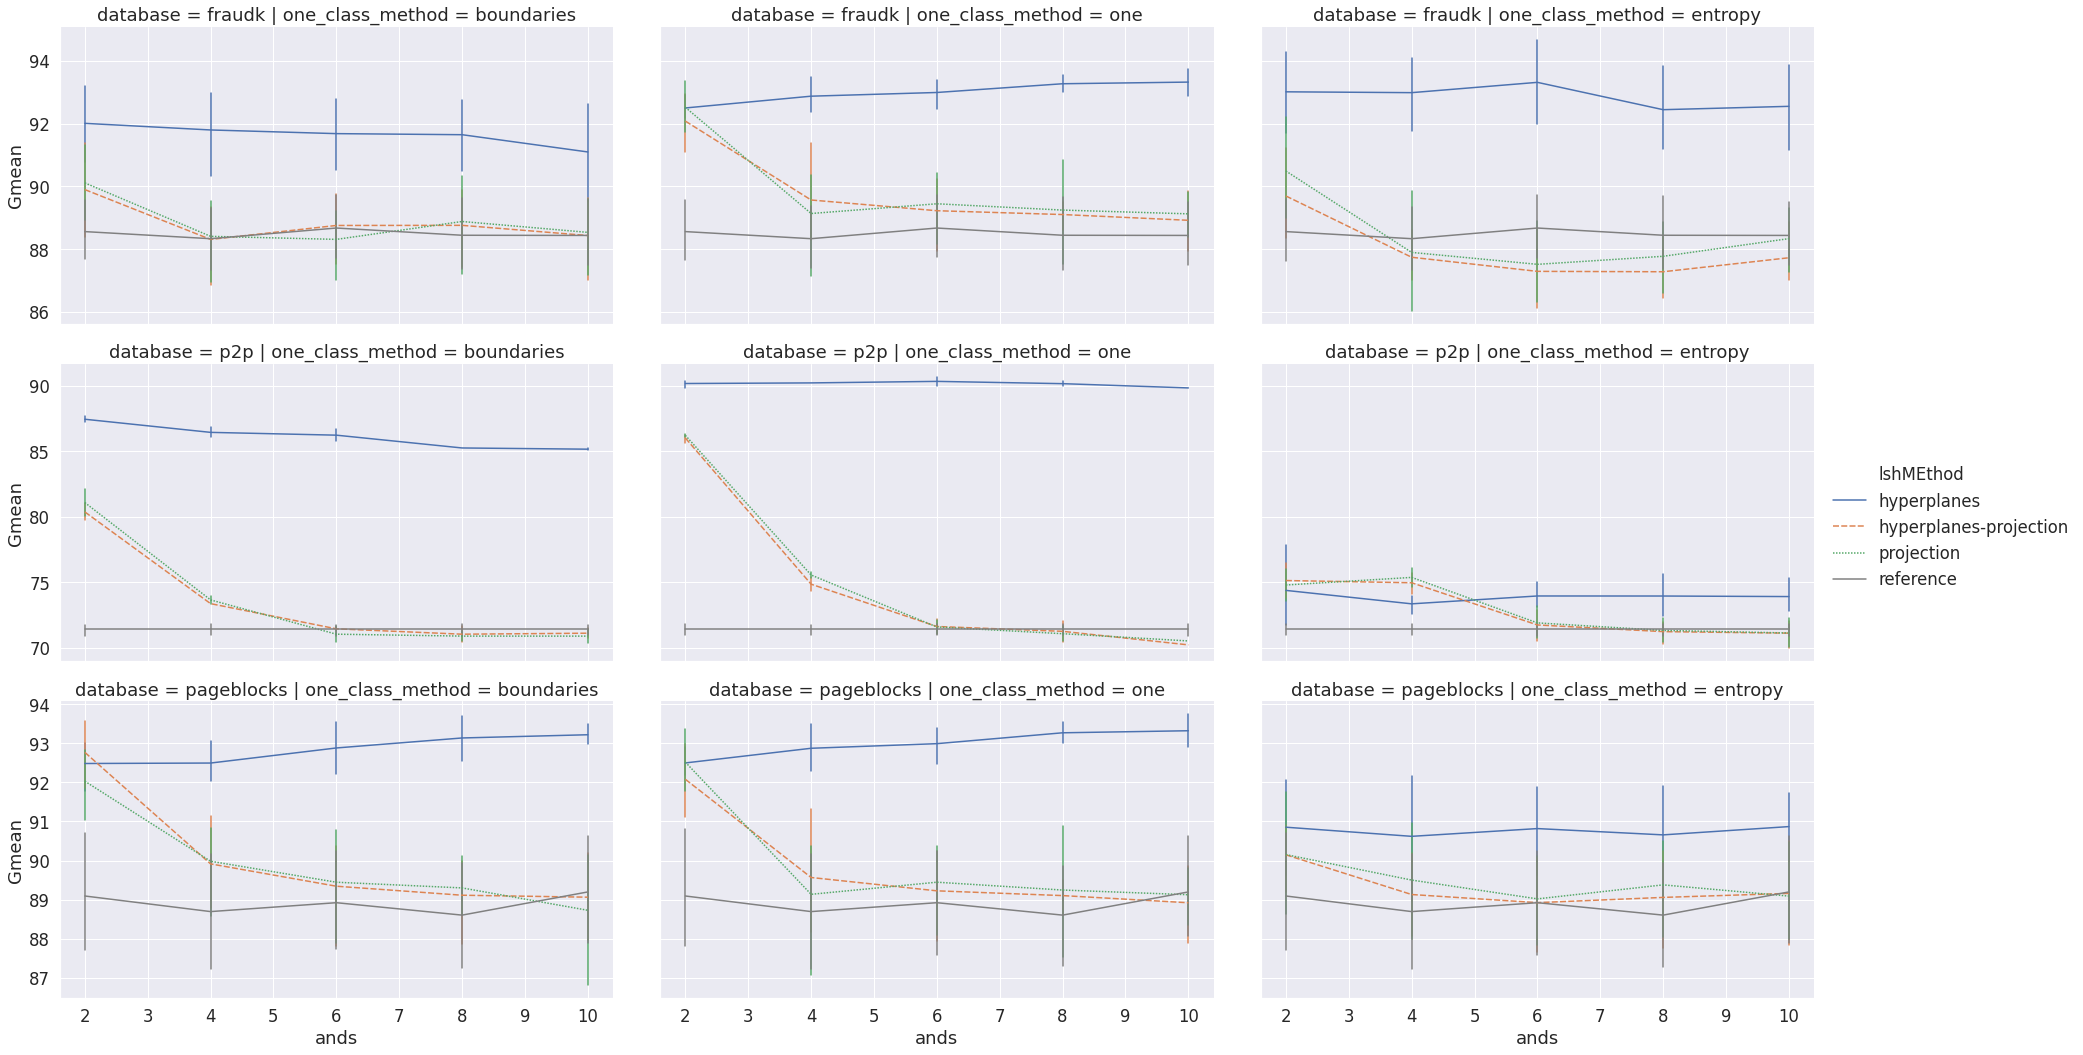

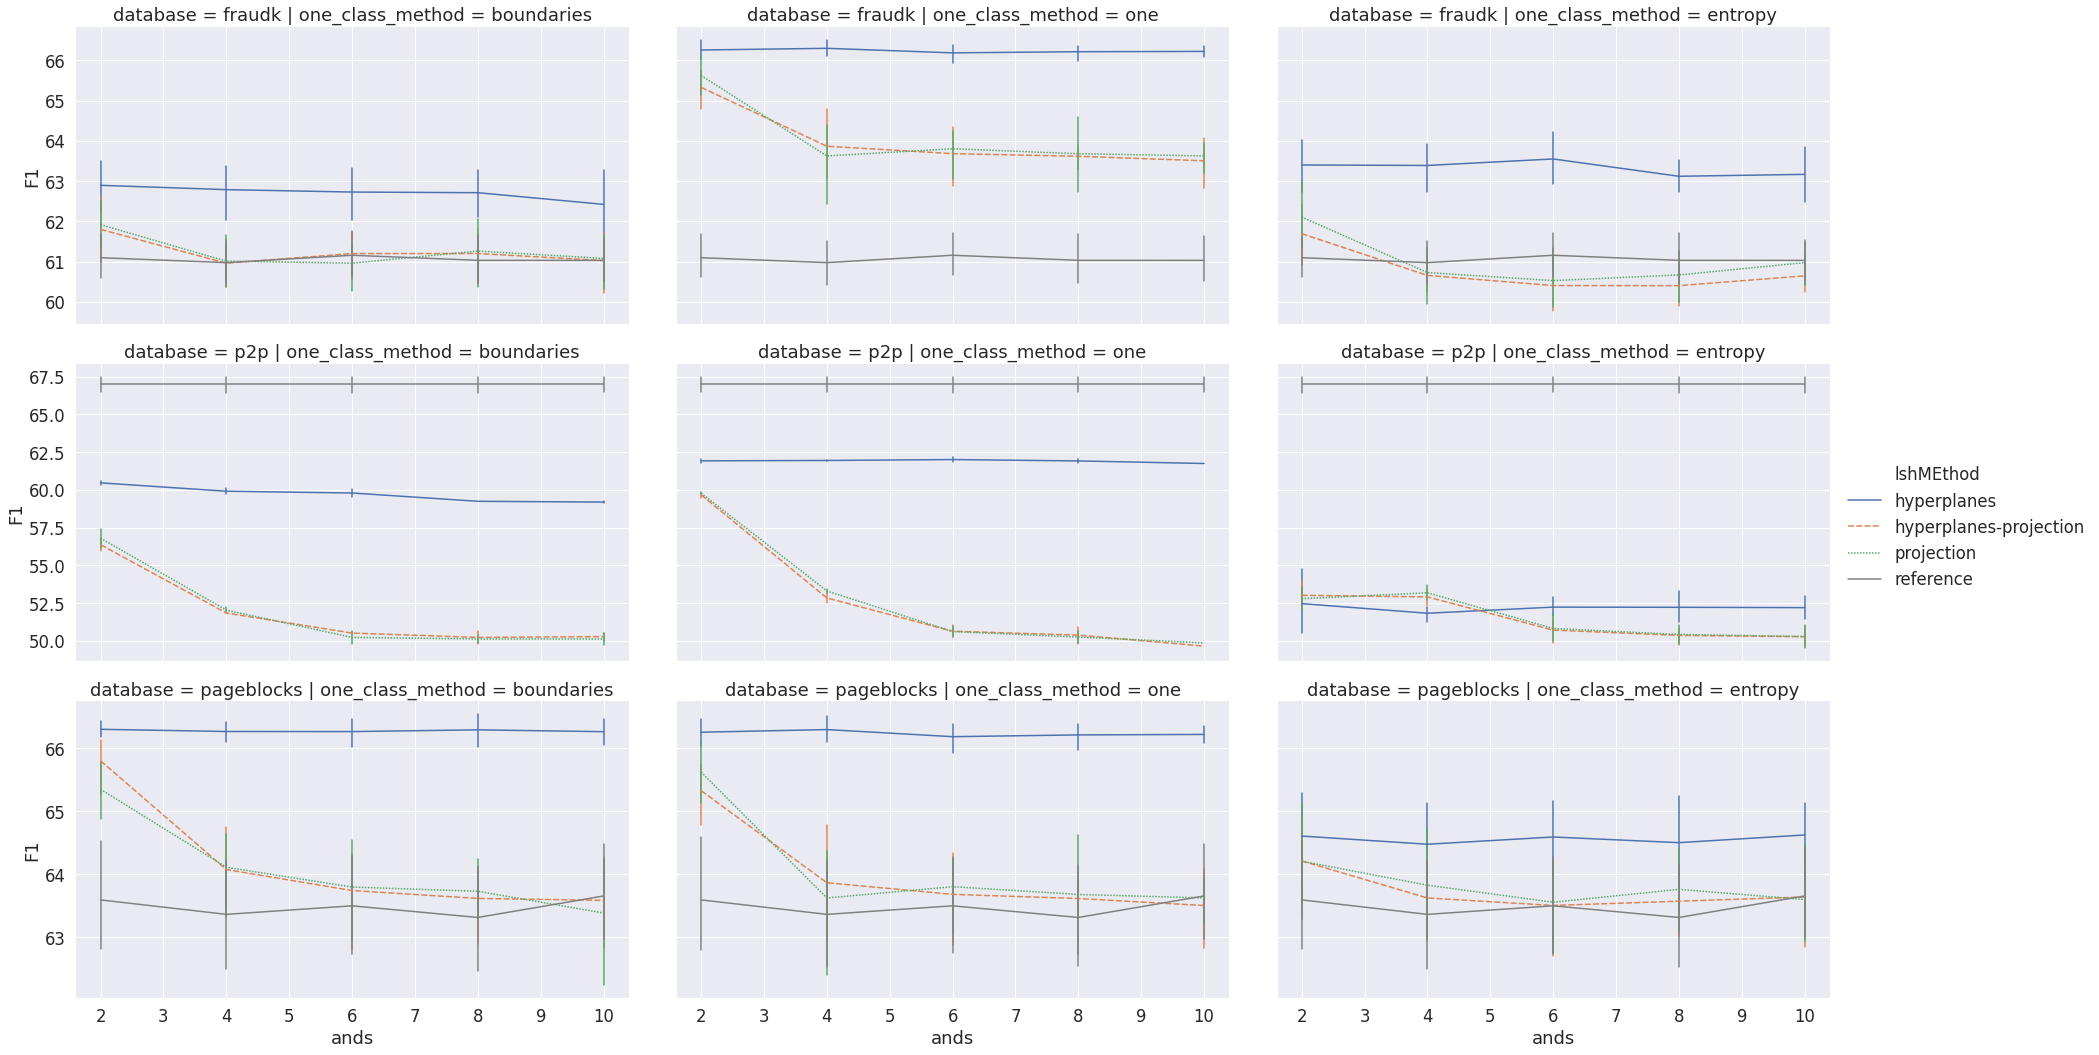

In [318]:
aspect = 1.5
sns.set(font_scale=1.5, style='darkgrid')
results_dedup = drop3_entropy.drop_duplicates(cols_to_dedup +[ 'one_class_method'])
cond= results_dedup.imbalance == True

plot_9_results(results_dedup, cond, best_no_is, measure= 'Gmean', measure_for_best='Gmean')
plot_9_results(results_dedup, cond, best_no_is, measure= 'F1', measure_for_best='F1')

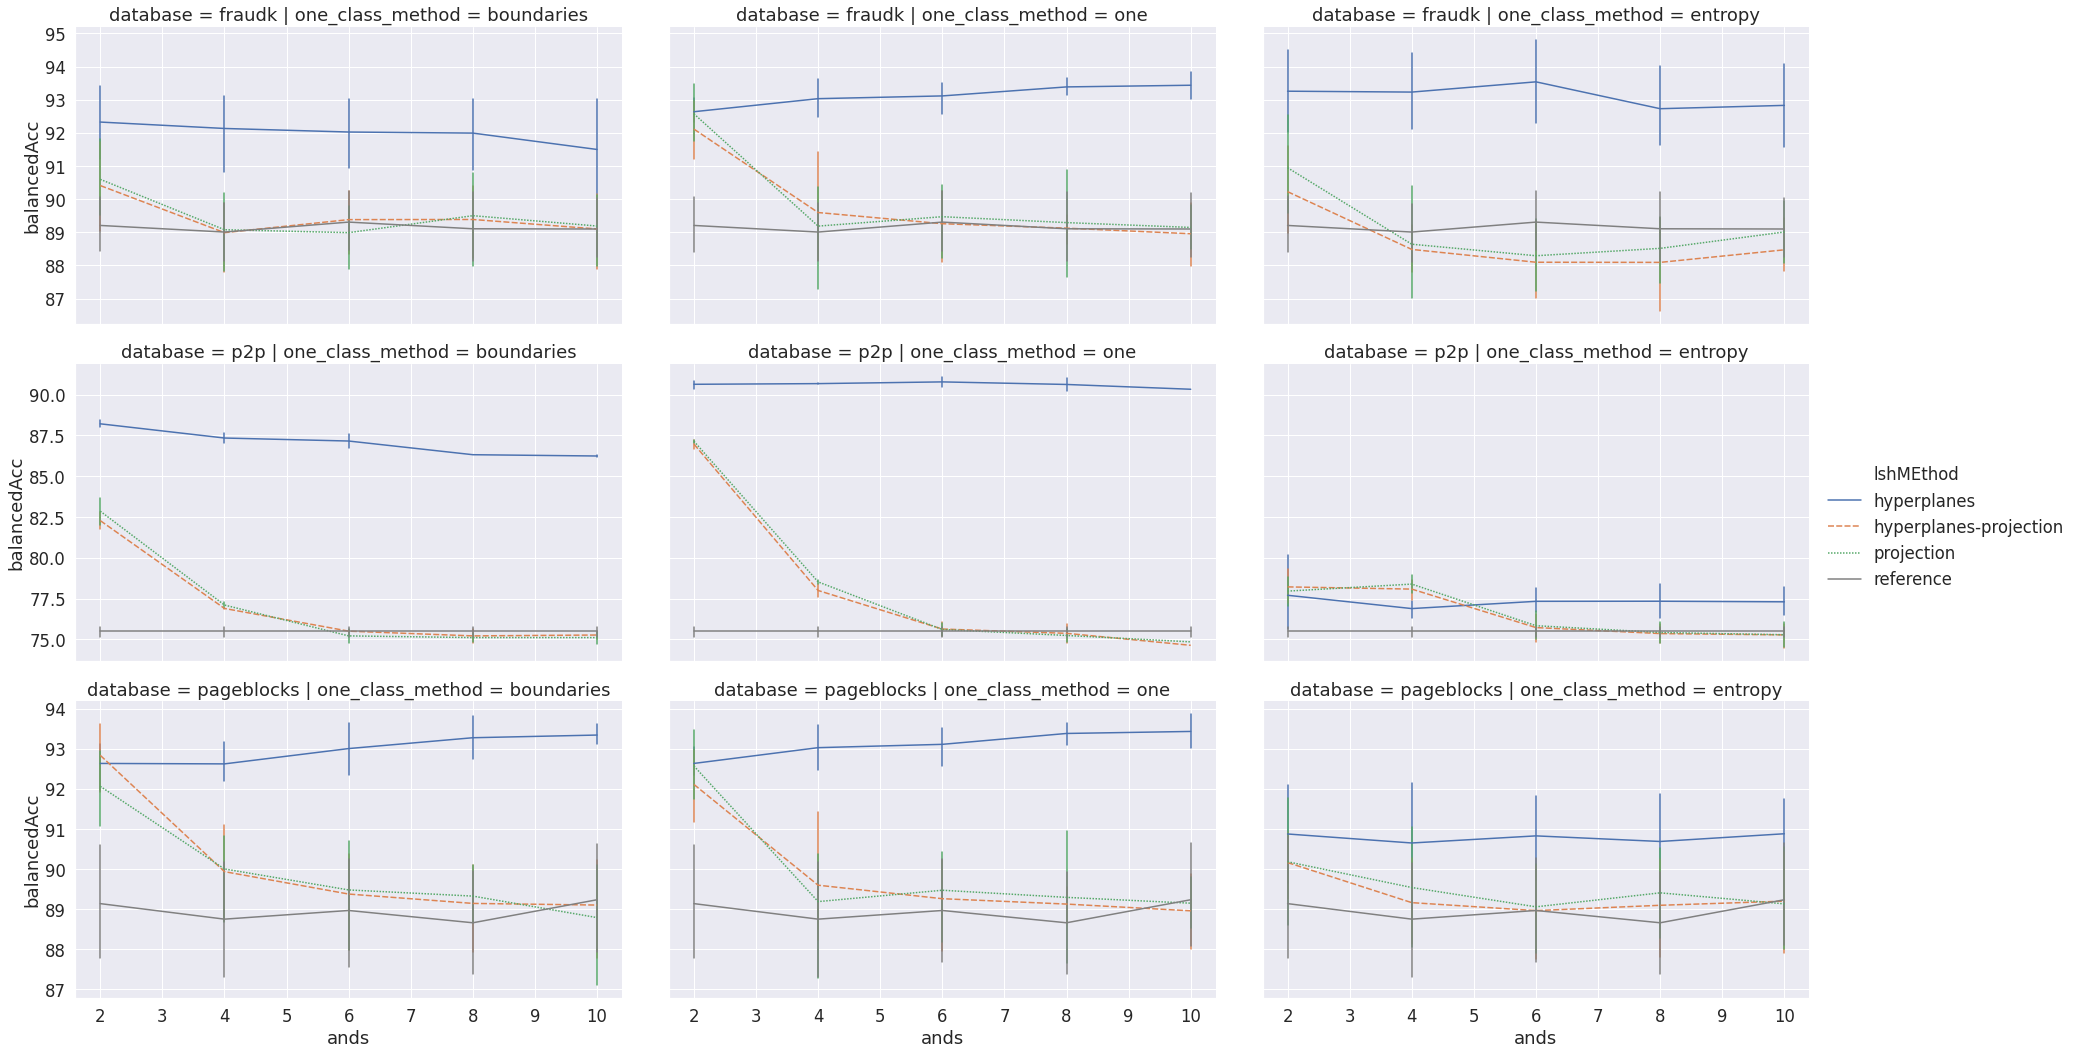

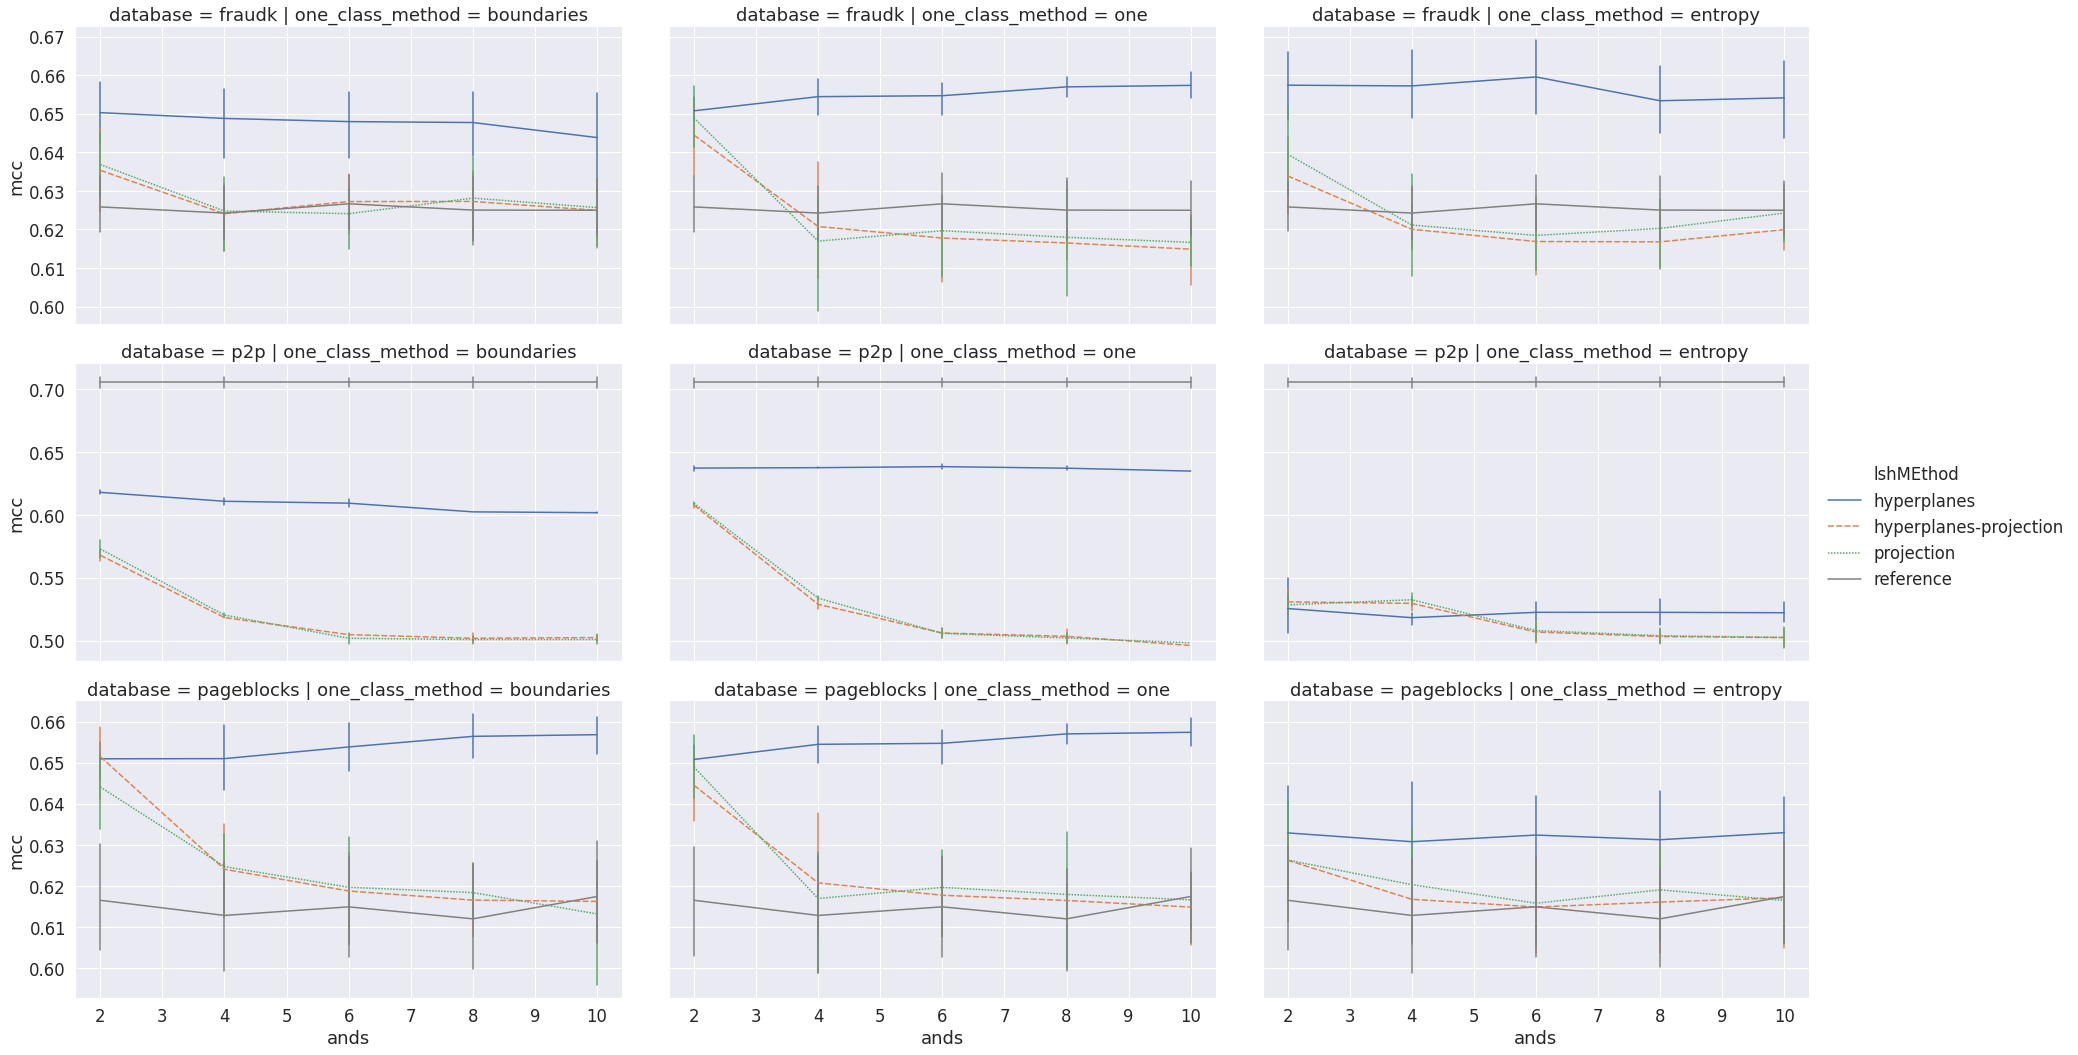

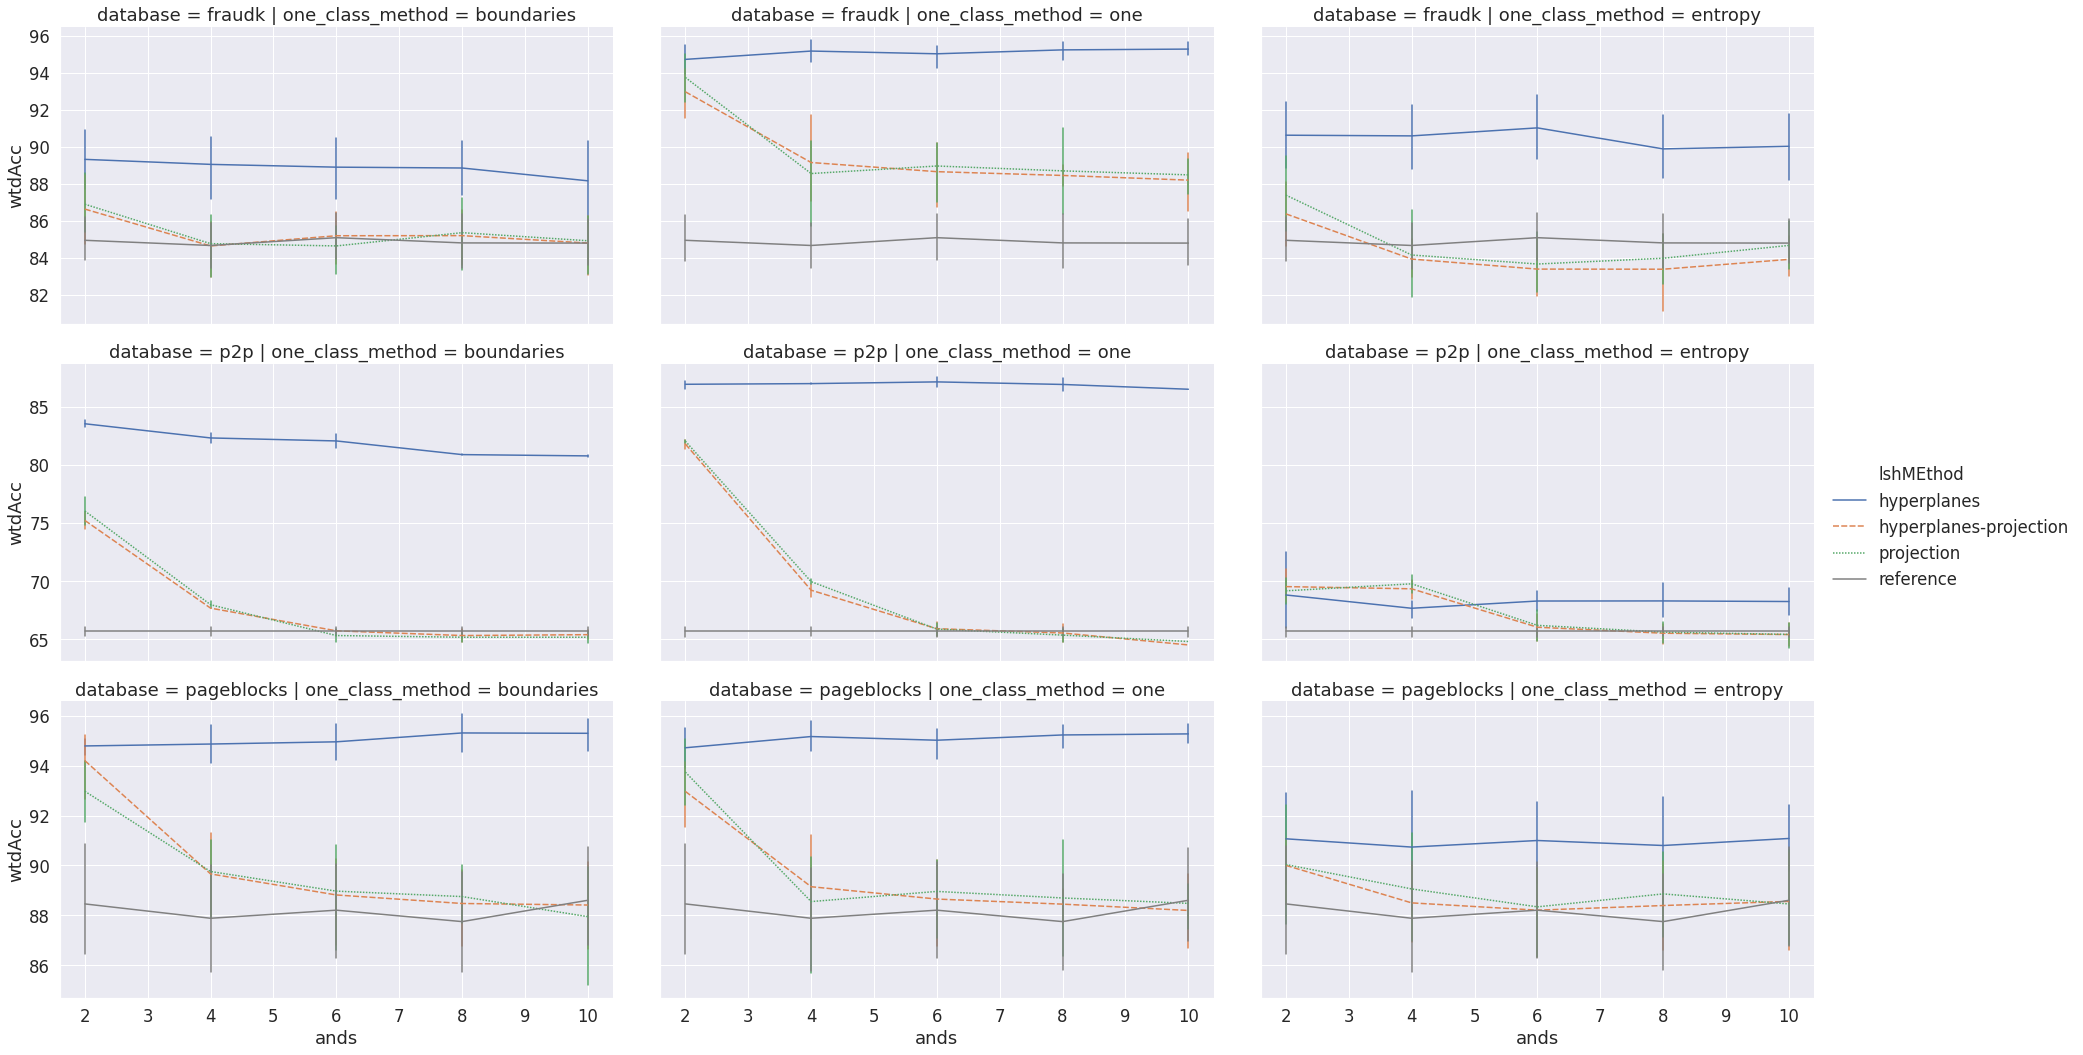

In [319]:
plot_9_results(results_dedup, cond, best_no_is, measure= 'balancedAcc', measure_for_best='balancedAcc')
plot_9_results(results_dedup, cond, best_no_is, measure= 'mcc', measure_for_best='mcc')
plot_9_results(results_dedup, cond, best_no_is, measure= 'wtdAcc', measure_for_best='wtdAcc')

## plots 3

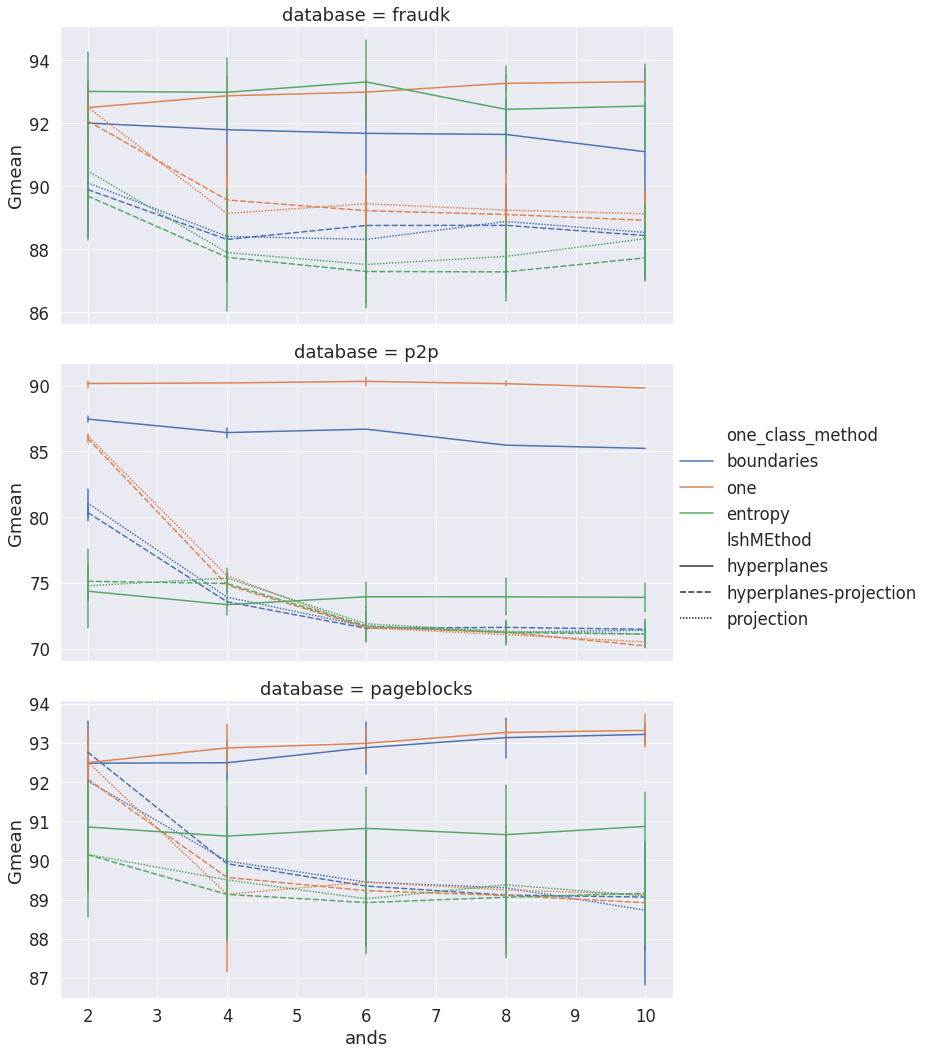

In [301]:
aspect = 2
sns.set(font_scale=1.5, style='darkgrid')

df_in=results_dedup.copy(); 
cond= results_dedup.imbalance == True
df_reference= best_no_is
measure = 'Gmean'; measure_for_best = 'Gmean'

df = (df_in[cond].groupby(factorsIS)
                .apply(lambda g : ut.get_best_for(g, measures, measure_sort = measure_for_best, factorsModel = factorsModel))
                .reset_index())

g = sns.relplot(data = df[df.type=='test'], x ='ands', 
            y= measure, 
            row = 'database', 
            style = 'lshMEthod', 
            hue = 'one_class_method', 
            kind = 'line', 
            aspect = aspect,
            facet_kws = {'sharey': 'row'},
            err_style =  'bars',  legend = 'brief')

## Plot for analysis lsh and is

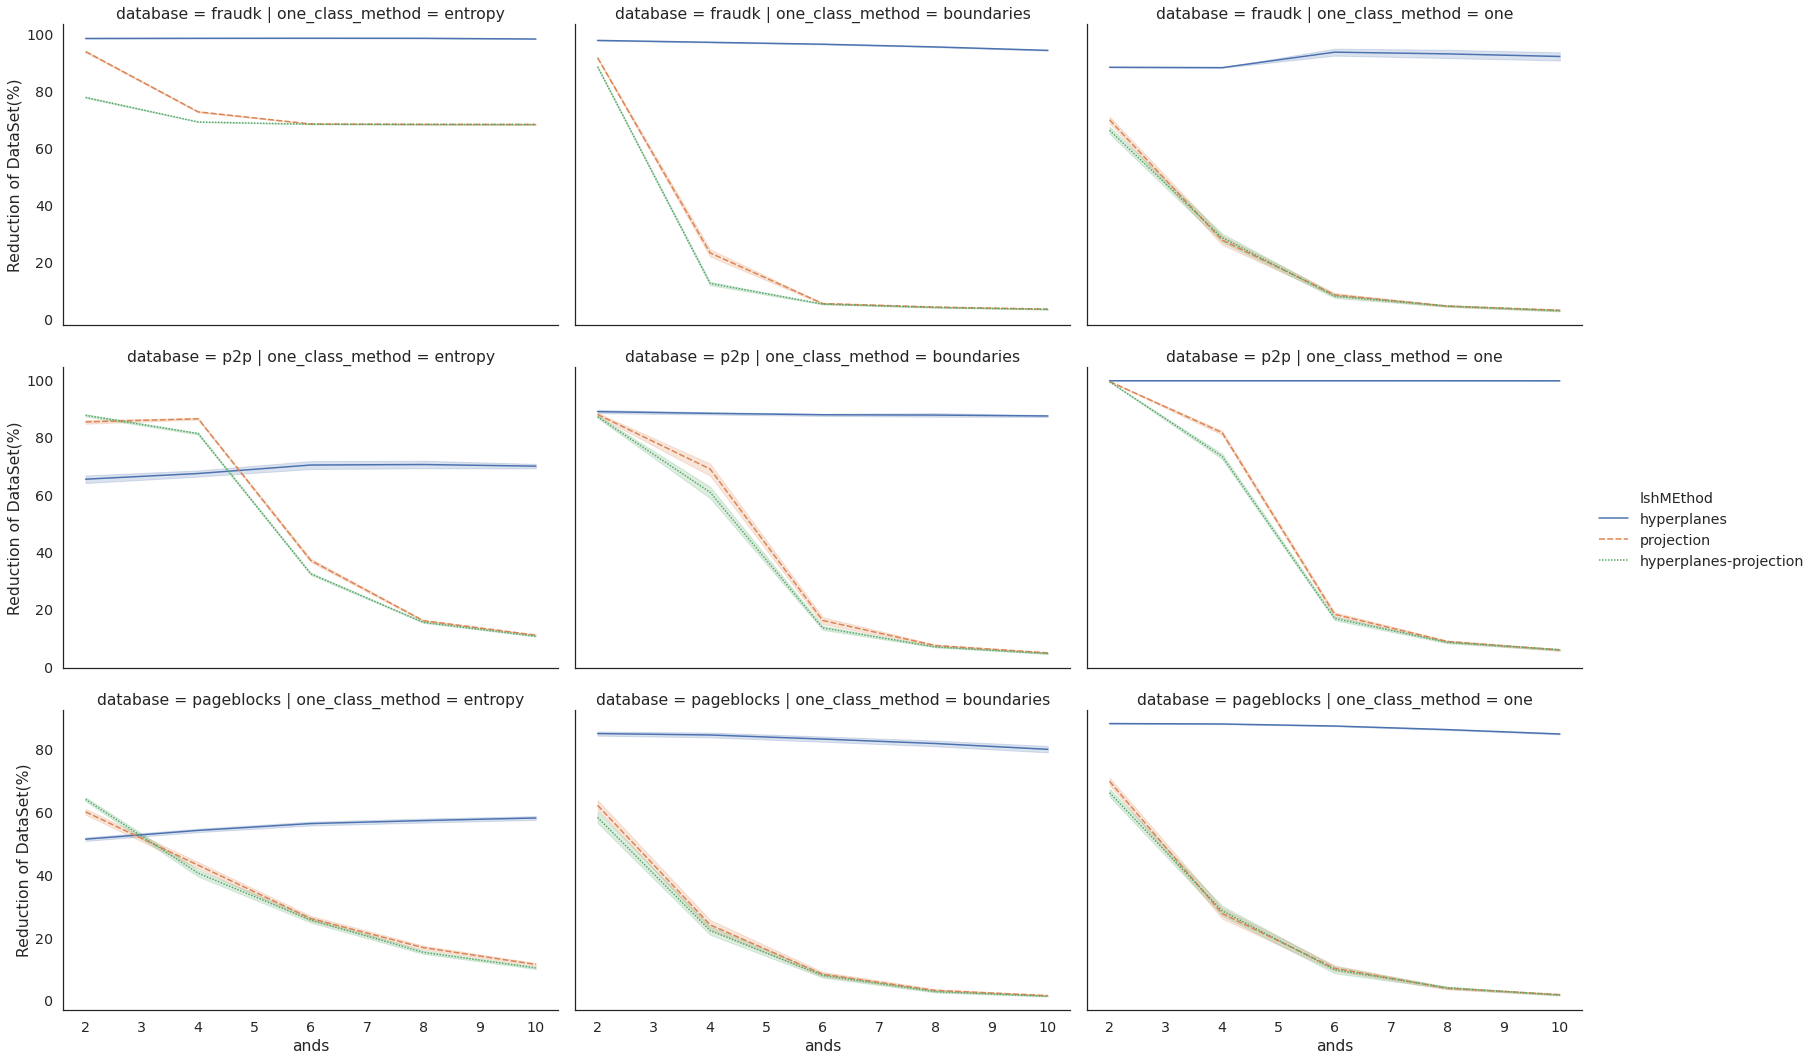

In [17]:
df = drop3_entropy[drop3_entropy.type == 'Train'].copy()
g= sns.relplot(x="ands", y='Reduction of DataSet(%)', hue = 'lshMEthod',
        style = 'lshMEthod', 
        aspect=aspect, 
        row = 'database', 
        col = 'one_class_method',
        kind = 'line',
        data=df,
        legend = 'full', 
        facet_kws = {'sharey': 'row'})
g.savefig(f"report/reduction.png")

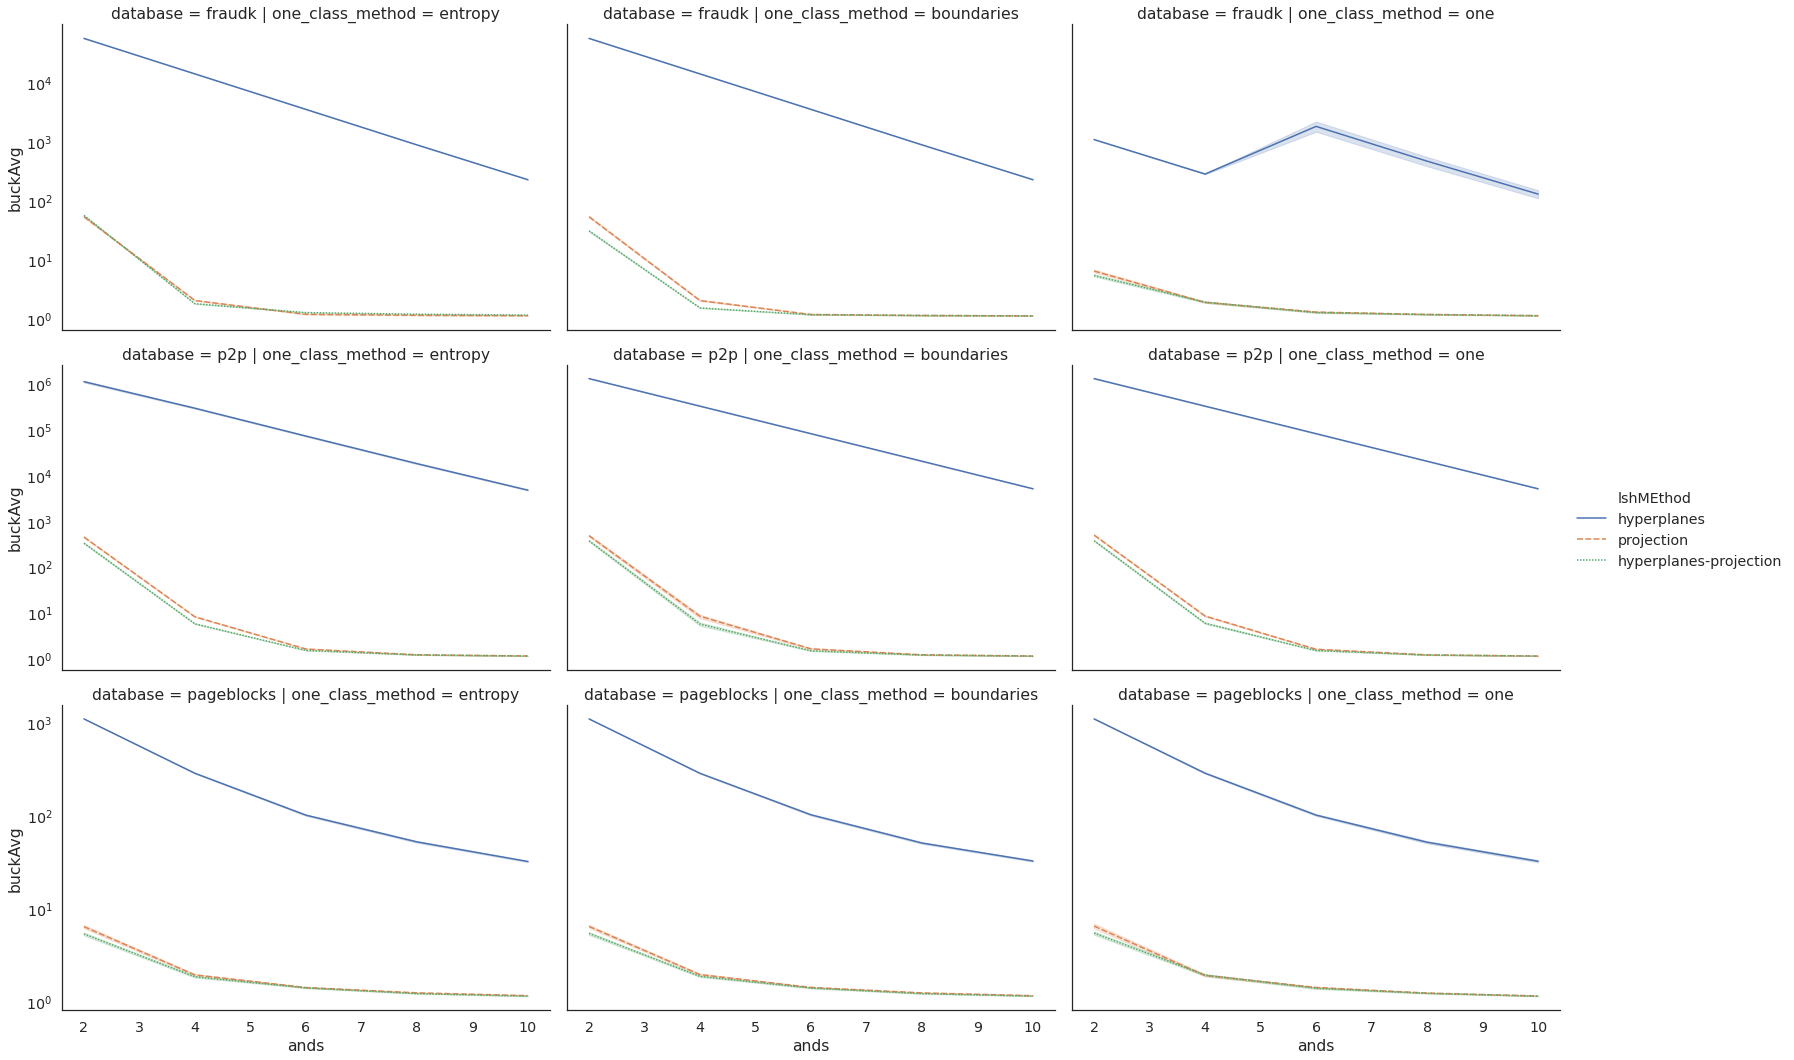

In [21]:
df = drop3_entropy[drop3_entropy.type == 'Train'].copy()
g= sns.relplot(x="ands", y='buckAvg', hue = 'lshMEthod',
        style = 'lshMEthod', 
        aspect=aspect, 
        row = 'database', 
        col = 'one_class_method',
        kind = 'line',
        data=df,
        legend = 'full', 
        facet_kws = {'sharey': 'row'}, )
for ax in np.ravel(g.axes):
    ax.set_yscale('log')
g.savefig('report/bucket.png')